In [1]:
#################### Percent of Time SSC in Top 1 Meter Above Threshold ##########################
# The purpose of this script is to plot the percent of time that the SSC in the top 1 m
# of the water column is above a certain user-specified threshold(s)

# Notes:
# - 
#
####################################################################################################

In [2]:
# Load in the packages 
import numpy as np
import xarray as xr
import xesmf as xe
import pandas as pd
import xroms 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import cmocean 
import scipy.io
from glob import glob
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib import colors

In [3]:
# Set a universal fontsize
fontsize = 20

# Set the tick size for all plots
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)

# Prevent tick labels from overlapping
matplotlib.rcParams['xtick.major.pad'] = 10
matplotlib.rcParams['ytick.major.pad'] = 10

#### Load in Things

In [4]:
# Load in the grid
grid = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Include/KakAKgrd_shelf_big010_smooth006.nc')
#grid = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Grids/KakAKgrd_shelf_big010_smooth006.nc')

# Pull out some dimensions
eta_rho_len = len(grid.eta_rho)
xi_rho_len = len(grid.xi_rho)

# Load in the rho masks
mask_rho_nan = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_ones_nans.nc') # UPDATE PATH
mask_rho_zeros = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_zeros_ones.nc')
#mask_rho_nan = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_ones_nans.nc')
#mask_rho_zeros = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_zeros_ones.nc')

#### Make Functions

In [5]:
# Define a function to pull out the lenght of time in the model run
# And the time steps
def get_model_time(filenames, num_files):
    """
    This function loops though model output and pulls
    out the entire length of the run, as well as the 
    individual time steps of the run.
    
    Inputs:
    - filenames: path and name of model output
    - num_files: the number of model output files
    
    Outputs:
    - time_len: length of time of model run (integer)
    - time_steps_list: list of time steps of full run (datetimes64)
    - time_lengths: array holding the lenght of time of each output file
    """

    # Create an array to hold the length of time in each output file
    time_lengths = np.empty((num_files))

    # Loop through output to pull out lenth of time
    for k in range(num_files):
        # Open the output file
        model_output = xr.open_dataset(filenames[k])

        # Pull out the length of time 
        time_lengths[k] = len(model_output.ocean_time)

    # Now sum over all the lengths to get total time
    time_len = np.sum(time_lengths, axis=0)

    # Convert from float to int
    time_len = int(time_len)

    # Loop back through the output to pull out the time step and save it
    # Make a list to hold the time steps 
    time_steps_list = []
    # Loop through output
    for h in range(num_files):
        # Open the output file
        model_output = xr.open_dataset(filenames[h])

        # Get the length of the run
        output_len = len(model_output.ocean_time)

        # Loop through each time step and append it to the list
        for g in range(output_len):
            time_steps_list.append(model_output.ocean_time[g].values)

    # Return this time length and time steps
    return(time_len, time_steps_list, time_lengths)


In [6]:
# Make a  function to interpolate the ROMS data to a given depth (measured from
# top down and negative)
def interp_roms_ssc_from_top(filenames, time_len, eta_rho_len, xi_rho_len, time_lengths, num_files, depths, threshold):
    """
    This function takes all given ROMS ocean_his files, opens one at a time and 
    interpolates total SSC onto the given depths, then returns the interpolated
    data. Right now, it is set up to interpolate total SSC.
    
    Inputs:
    - filenames: path and name of model output
    - time_len: full length of time of all model outputs combined 
    - eta_rho_len: length of eta dimension
    - xi_rho_len: length of xi dimension
    - time_lengths: lengths of time for each model output
    - num_files: the number of model output files
    - depths: the depths to interpolate the data onto 
    - threshold: SSC threshold to see how often the data is above (kg/m3)
    Outputs:
    - tot_ssc_top_1m: Time series of total SSC 1 m above the seafloor (over all space)
    

    Returns
    -------
    None.

    """
    # Make empty arrays to hold the data
    tot_ssc_top_1m = np.empty((time_len, len(depths), eta_rho_len, xi_rho_len))
    avg_tot_ssc_top_1m = np.empty((time_len, eta_rho_len, xi_rho_len))
    time_above_threshold_01_cnt = np.empty((num_files, eta_rho_len, xi_rho_len))
    
    # Set the initial time step
    time_step = 0
    
    # Loop through each output file
    for jj in range(num_files):
        print('jj for top 1 m:' , jj)
        # Load in the ROMS output 
        ds = xr.open_dataset(filenames[jj])
        #ds = xr.open_dataset(filenames)
        ds['h'] = ds.bath
        ds, xgrid = xroms.roms_dataset(ds)
    
        # Get the depths as height from seabed
        height_from_seabed = ds.z_rho + ds.bath
        height_from_seabed.name = 'z_rho'
    
        # Set two depths, 1 m above seafloor
        #depths = np.asarray([1.0])

        # Interopolate onto the given CODA depths
        ssc_allsed_interp_top_1m = xroms.isoslice((ds.sand_01+ds.sand_02+ds.sand_03+ds.mud_01+ds.mud_02+ds.mud_03+ds.mud_04+ds.mud_05+ds.mud_06+
                                                   ds.mud_07+ds.mud_08+ds.mud_09+ds.mud_10+ds.mud_11+ds.mud_12+ds.mud_13+ds.mud_14+ds.mud_15+ds.mud_16+
                                                   ds.mud_17+ds.mud_18+ds.mud_19+ds.mud_20+ds.mud_21+ds.mud_22+ds.mud_23+ds.mud_24), depths, xgrid)
    
        
        # Take the average over depth
        #tot_ssc_top_1m_avg = np.nanmean(ssc_allsed_interp_top_1m, axis=1)
        tot_ssc_top_1m_avg = ssc_allsed_interp_top_1m.mean(axis=1, skipna=True)
        
        # Get the number of times steps this is above a threshold
        time_above_threshold_01_cnt_tmp = (tot_ssc_top_1m_avg.where(tot_ssc_top_1m_avg > threshold).groupby('eta_rho',).count(dim='ocean_time'))
        
        # Save these to the arrays 
        #print('time_step: ', time_step)
        #print('time_step + time_lengths[j]: ', time_step+time_lengths[j])
        start = int(time_step)
        end = int(time_step+time_lengths[jj])
        #end = int(time_step+time_lengths)
        tot_ssc_top_1m[start:end,:,:,:] = ssc_allsed_interp_top_1m
        avg_tot_ssc_top_1m[start:end,:,:] = tot_ssc_top_1m_avg
        time_above_threshold_01_cnt[jj,:,:] = time_above_threshold_01_cnt_tmp
        
        # Update the base time_step
        time_step = time_step + time_lengths[jj]
        #time_step = time_step + time_lengths

    # Now combine all of the counts to get total counts/all time
    tot_cnt_time_above_threshold_01 = np.sum(time_above_threshold_01_cnt, axis=0)
     
    # Return the ssc
    return(tot_ssc_top_1m, avg_tot_ssc_top_1m, tot_cnt_time_above_threshold_01)
    #return(tot_ssc_top_1m, avg_tot_ssc_top_1m, time_above_threshold_01_cnt_tmp)

#### Process the Data

In [7]:
# Want a time series of average SSC in top 1 m over all space and time 
# Loop through model output and call the function
# First, get all the file names 
# For now, use the run where the unique class is unaggregated mud but might 
# want to make version with aggregated mud, too, so see if the results are different 
# although they definitely shouldn't be

# ROMS aggregated output
# dbsed0001
file_names_agg = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_*.nc')

# Sort them to be in order
file_names_agg2 = sorted(file_names_agg)

# Check to see if this worked
print(file_names_agg2[0], flush=True)
print(file_names_agg2[1], flush=True)
print(file_names_agg2[2], flush=True)
print(file_names_agg2[-1], flush=True)

# Pull out the number of files
num_files_agg = len(file_names_agg2)

/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00001.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00002.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00003.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00019.nc


In [ ]:
# # TEMPORARY TEST
# file_names_agg = '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00001.nc'
# file_names_agg2 = file_names_agg
# num_files_agg=1

# ds = xr.open_dataset('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00001.nc')

In [ ]:
# Same but for unagregated
# ROMS aggregated output
# dbsed0001
#file_names_unag = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_003_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_unaggregated_dbsed0001_*.nc')

# Sort them to be in order
#file_names_unag2 = sorted(file_names_unag)

# Check to see if this worked
#print(file_names_unag2[0], flush=True)
#print(file_names_unag2[1], flush=True)
#print(file_names_unag2[2], flush=True)
#print(file_names_unag2[-1], flush=True)

# Pull out the number of files
#num_files_unag = len(file_names_unag2)

In [ ]:
# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
# Aggregated 
full_time_len_agg, time_steps_agg, time_lengths_agg = get_model_time(file_names_agg2, num_files_agg)

In [ ]:
# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
# Unaggregated 
#full_time_len_unag, time_steps_unag, time_lengths_unag = get_model_time(file_names_unag2, num_files_unag)

In [ ]:
# ------ SSC ------
# Interpolate it to the desired depths and determine the number
# of tme steps where it is above a given SSC threshold

# Set the SSC threshold
threshold_01 = 0.01 # kg/m3

# 1 m above seafloor
#tot_ssc_bot_1m, tot_ssc_og = interp_roms_ssc_to1m_rho(file_names2, full_time_len, s_rho_len, eta_rho_len, xi_rho_len, time_lengths, num_files)

# 1 m below surface
#depth_surf = np.asarray([-1])
#depths_surf = np.asarray([-0.5,-1])
depths_surf = np.asarray([-0.25,-0.75])
#tot_ssc_top_1m_agg = interp_roms_ssc_from_top(file_names_agg2, full_time_len_agg, eta_rho_len, xi_rho_len, time_lengths_agg, num_files_agg, depths_surf)  #OLD
# TEMPORARY TEST - NEW USE THIS
tot_ssc_top_1m_agg, avg_tot_ssc_top_1m_agg, tot_cnt_time_above_threshold_01_agg = interp_roms_ssc_from_top(file_names_agg2, full_time_len_agg, eta_rho_len, xi_rho_len, time_lengths_agg, num_files_agg, depths_surf, threshold_01)


In [ ]:
print('tot_ssc_top_1m_agg  shape: ', np.shape(tot_ssc_top_1m_agg ), flush=True)
print('avg_tot_ssc_top_1m_agg shape: ', np.shape(avg_tot_ssc_top_1m_agg), flush=True)
print('time_above_threshold_01_cnt_tmp: ', np.shape(tot_cnt_time_above_threshold_01_agg), flush=True)

In [ ]:
percent_time_above_threshold_01_agg = (tot_cnt_time_above_threshold_01_agg/len(ds.ocean_time.values))

In [ ]:
print('time_above_threshold_01 shape: ', np.shape(percent_time_above_threshold_01_agg), flush=True)

In [ ]:
print('percent_time_above_threshold_01_agg min: ', np.min(percent_time_above_threshold_01_agg).values, flush=True)
print('percent_time_above_threshold_01_agg max: ', np.max(percent_time_above_threshold_01_agg).values, flush=True)
print('percent_time_above_threshold_01_agg mean: ', np.mean(percent_time_above_threshold_01_agg).values, flush=True)

In [ ]:
# Assuming this all works, save the post-processed data to
# a netCDF just in case 
# -------------------------------------------------------------------------------
# ---- Make a netcdf to hold the output data used for plotting 
# -------------------------------------------------------------------------------
# Set up the data
roms_ssc_time_above_threshold = xr.Dataset(
    data_vars=dict(
        time_above_threshold_01=(['eta_rho','xi_rho'], percent_time_above_threshold_01_agg),
        ),
    coords=dict(
        xi_rho=('xi_rho', grid.xi_rho.values),
        eta_rho=('eta_rho', grid.eta_rho.values), 
        ),
    attrs=dict(description='Time above SSC threshold (0.01 kg/m3) for the unaggregated model runs')) 
# Add more metadata?
roms_ssc_time_above_threshold.time_above_threshold_01.name='fraction of time above SSC threshold (0.1 kg/m3) in aggregated mud run for average total SSC in top 1 m'

# Save to a netcdf
#roms_ssc_time_above_threshold.to_netcdf('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/time_ssc_top_1m_above_threshold_01.nc')




#### Plots!
If the post-processing is successfully done in plot_percent_time_ssc_above_value.py then start down here with loading the data and plotting it.

In [7]:
# Assuming the *.py version of this script successfully made
# the data into a netcdf, plot the data

# Load in the data
# Aggregated 
#time_above_threshold_agg = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/time_ssc_top_1m_above_threshold_01_agg.nc')
time_above_threshold_agg = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/time_ssc_top_1m_above_three_thresholds_agg.nc')
# Unaggregated
time_above_threshold_unag = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/time_ssc_top_1m_above_three_thresholds_unag.nc')

In [8]:
time_above_threshold_agg

<xarray.Dataset> Size: 3MB
Dimensions:                  (eta_rho: 206, xi_rho: 608)
Coordinates:
  * xi_rho                   (xi_rho) float64 5kB 0.0 1.0 2.0 ... 606.0 607.0
  * eta_rho                  (eta_rho) float64 2kB 0.0 1.0 2.0 ... 204.0 205.0
Data variables:
    time_above_threshold_01  (eta_rho, xi_rho) float64 1MB ...
    time_above_threshold_02  (eta_rho, xi_rho) float64 1MB ...
    time_above_threshold_03  (eta_rho, xi_rho) float64 1MB ...
Attributes:
    description:  Time above SSC three thresholds (0.001, 0.01, 0.05 kg/m3) f...

In [9]:
# Load in some packages for plotting 
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.ticker as tick
from matplotlib import cm, ticker
import warnings
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
crs = ccrs.PlateCarree()
warnings.filterwarnings("ignore") #turns off annoying warnings
#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

In [10]:
river_marker_colors = ['#FC440F', '#F5ED00', '#5EF38C', '#26532B', '#F43ECF', '#9C00A8',
                       '#0115F5', '#00A6A6', '#AB64EB', '#D44179', '#08E0E3', '#B27009', '#EA8D40']

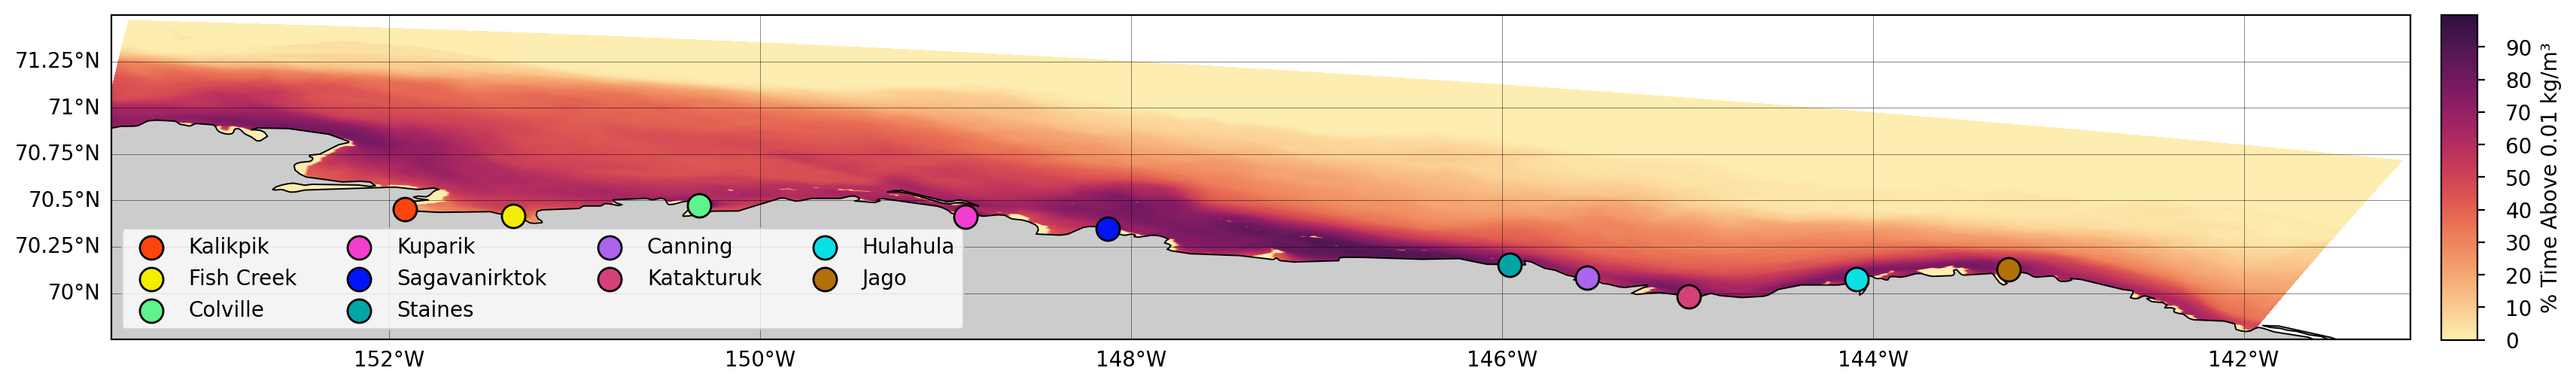

In [11]:
# Plot this percentage
# Make the figure
fig, ax = plt.subplots(figsize=(16,6), dpi=200,
                       constrained_layout=True,
                       subplot_kw={'projection': crs}) # figsize=(12,4.5). (16,6)
# Set the overall title/time
#fig1.suptitle('Time: ' + str(ds.ocean_time.values[t])[:10], x=0.5, y=1.02)

min_pcnt = 0
max_pcnt = 100
lev_pcnt = np.arange(min_pcnt, max_pcnt, 0.1)

cs1 = ax.contourf(grid.lon_rho.values, grid.lat_rho.values, time_above_threshold_agg.time_above_threshold_01*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)

# Plot the colorbar 
cbar_ax1 = fig.add_axes([1.01,0.32,0.015,0.36])
cbar1 = plt.colorbar(cs1,ax=ax,extend='max',
             label='% Time Above 0.01 kg/m\u00b3',
             pad=0.005, cax=cbar_ax1)

# Set extent and map features
ax.set_extent([-153.5,-141.1,69.75, 71.5],ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                            facecolor='0.8'), linewidth=.7)
ax.coastlines(resolution='10m', linewidth=.7)

# Plot the gridlines and stuff?
gl1 = ax.gridlines(crs=ccrs.PlateCarree(), 
                  draw_labels=True, 
                  x_inline=False, y_inline=False, 
                  linewidth=0.33, color='k',alpha=0.5)
gl1.right_labels = gl1.top_labels = False
gl1.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
gl1.xlabel_style = {'rotation': 0, 'ha': 'center'}

#ax.set_title('Time: ' +str(ds.ocean_time.values[t])[:10] + '\nSurface Salinity & Stress') #Only display yyyy-mm-dd

# Add in the rivers
# Plot the 14 rivers in the grid
# Go from West to East
# Kalikpik River
eta_kal_idx = 23 #22
xi_kal_idx = 87
s1 = ax.scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik',
            transform=ccrs.PlateCarree(), zorder=500)

# Fish Creek
eta_fis_idx = 20
xi_fis_idx = 117 #116
s2 = ax.scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek',
            transform=ccrs.PlateCarree(), zorder=500)

# Colville River
eta_col_idx = 39
xi_col_idx = 166 #166
s3 = ax.scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville',
            transform=ccrs.PlateCarree(), zorder=500)

# Kuparik
# Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
# of the Kuparuk River
eta_kuk_idx = 41 #40
xi_kuk_idx = 239
eta_kup_idx = 41 #40
xi_kup_idx = 242
s5 = ax.scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik',
            transform=ccrs.PlateCarree(), zorder=500)

# Sagavanirktok River
eta_sag_idx = 37 #36
xi_sag_idx = 279
s9 = ax.scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok',
            transform=ccrs.PlateCarree(), zorder=500)

# Canning River
# Staines River
eta_sta_idx = 27 #26
xi_sta_idx = 393
s10 = ax.scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines',
            transform=ccrs.PlateCarree(), zorder=500)

# Canning River
eta_can_idx = 20 #19
xi_can_idx = 416
s11 = ax.scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning',
            transform=ccrs.PlateCarree(), zorder=500)

# Katakturuk River
eta_kat_idx = 9 #8
xi_kat_idx = 447
s12 = ax.scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk',
            transform=ccrs.PlateCarree(), zorder=500)

# Hulahula River
eta_hul_idx = 40
xi_hul_idx = 489
s13 = ax.scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula',
            transform=ccrs.PlateCarree(), zorder=500)

# Jago River
eta_jag_idx = 62 #61
xi_jag_idx = 528
s14 = ax.scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago',
            transform=ccrs.PlateCarree(), zorder=500)

# Make a legend
ax.legend(ncol=4, loc='lower left')

# Plot the plot?
fig.canvas.draw()
 

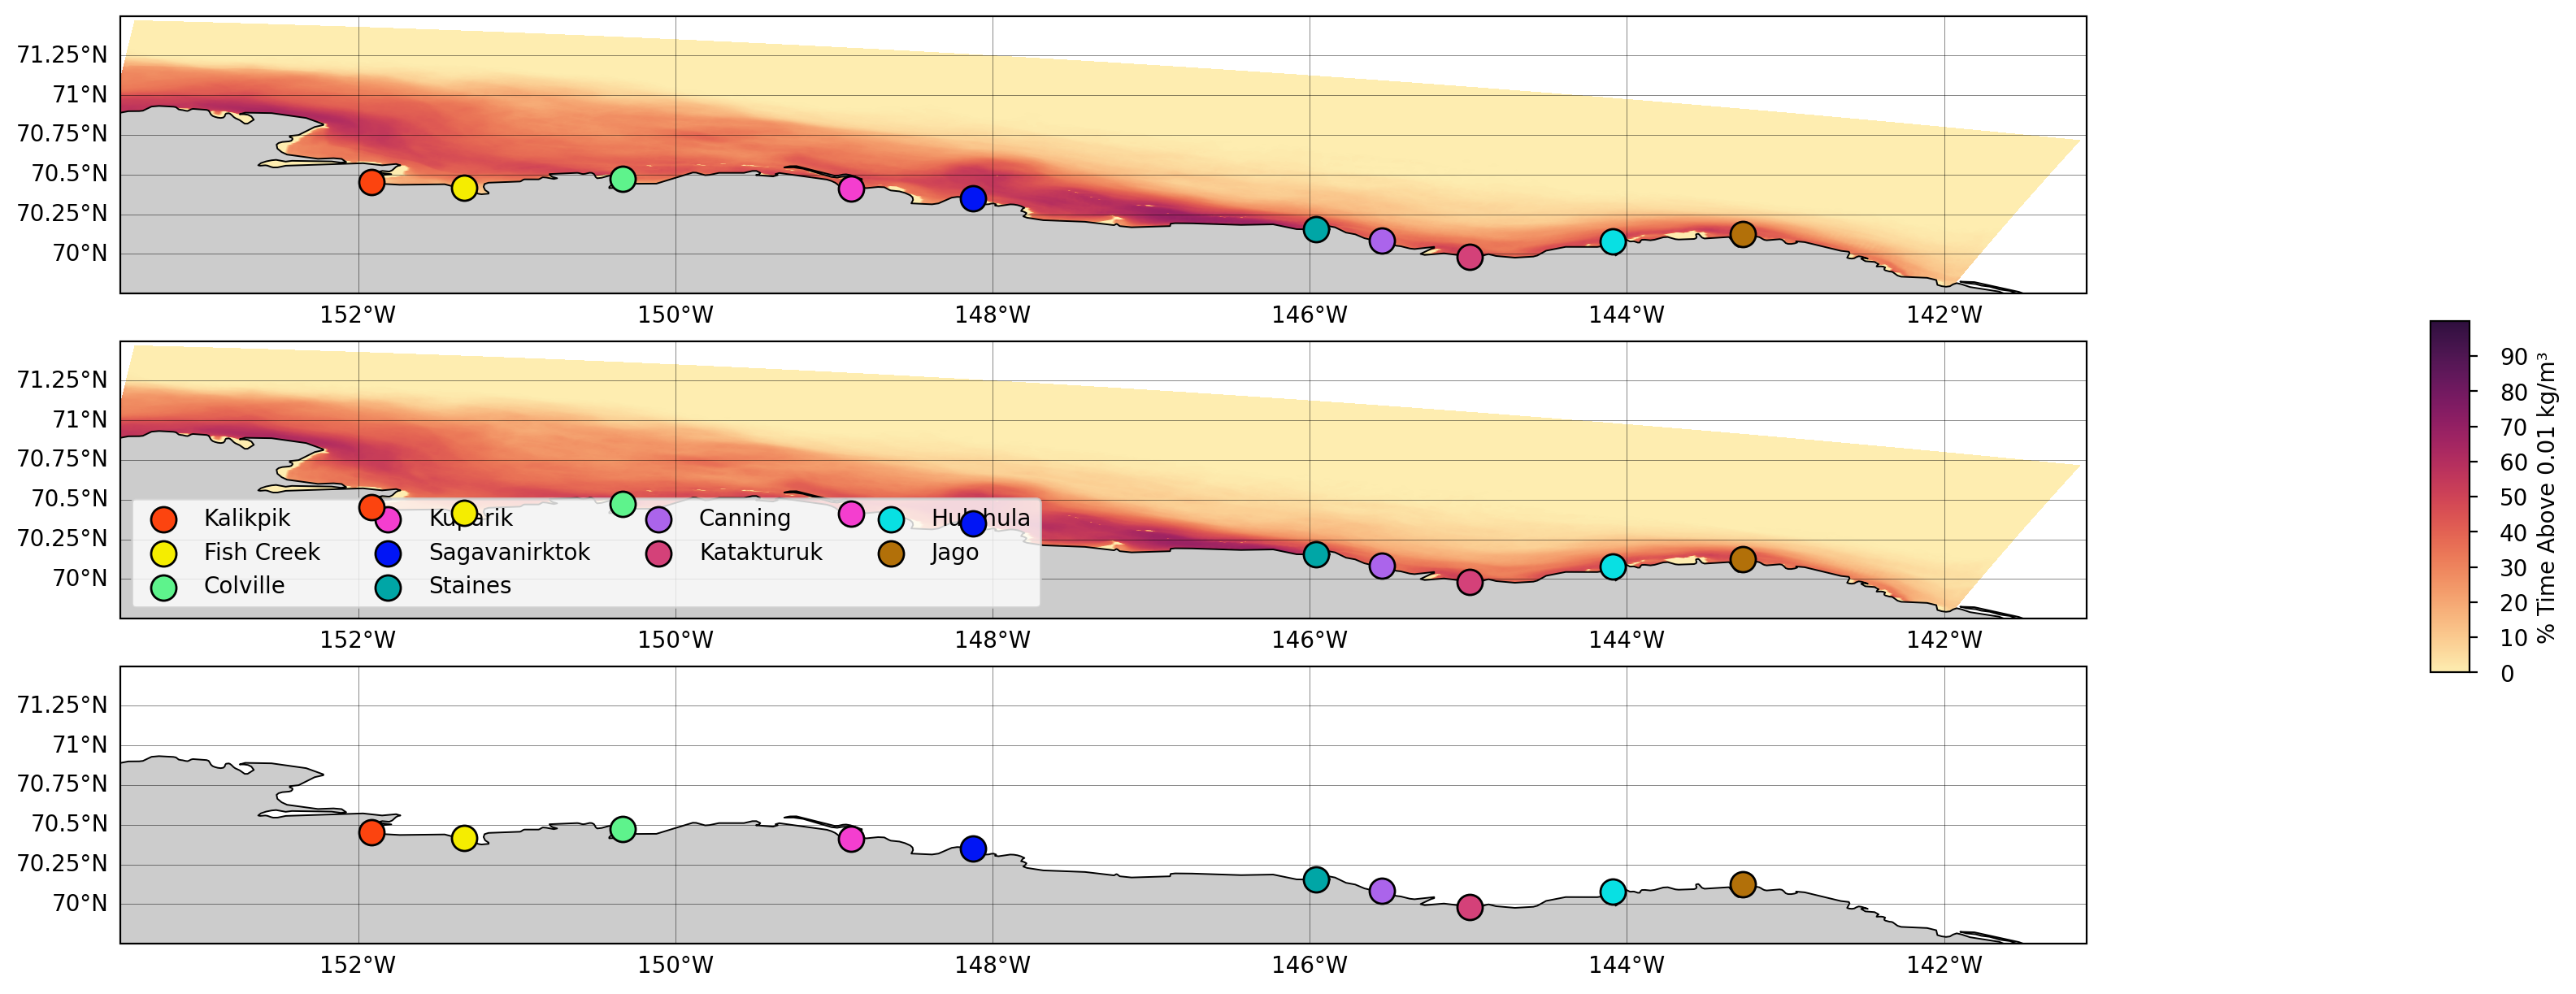

In [12]:
# Make the same plot but for both aggregated and unaggrgegated mud

# Make the figure
fig, ax = plt.subplots(3, figsize=(16,6), dpi=200,
                       constrained_layout=True,
                       subplot_kw={'projection': crs}) # figsize=(12,4.5). (16,6)
# Set the overall title/time
#fig1.suptitle('Time: ' + str(ds.ocean_time.values[t])[:10], x=0.5, y=1.02)

cs2 = ax[0].contourf(grid.lon_rho.values, grid.lat_rho.values, time_above_threshold_agg.time_above_threshold_02*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)

cs3 = ax[1].contourf(grid.lon_rho.values, grid.lat_rho.values, time_above_threshold_unag.time_above_threshold_02*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)

cs3 = ax[2].contourf(grid.lon_rho.values, grid.lat_rho.values, (time_above_threshold_unag.time_above_threshold_02-time_above_threshold_agg.time_above_threshold_01)*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)

# Plot the colorbar 
cbar_ax1 = fig.add_axes([1.01,0.32,0.015,0.36])
cbar1 = plt.colorbar(cs3,ax=ax[:],extend='max',
             label='% Time Above 0.01 kg/m\u00b3',
             pad=0.005, cax=cbar_ax1)

#ax.set_title('Time: ' +str(ds.ocean_time.values[t])[:10] + '\nSurface Salinity & Stress') #Only display yyyy-mm-dd


# Loop through axes and plot the river mouths
for r in range(3):

    # Set extent and map features
    ax[r].set_extent([-153.5,-141.1,69.75, 71.5],ccrs.PlateCarree())
    ax[r].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='0.8'), linewidth=.7)
    ax[r].coastlines(resolution='10m', linewidth=.7)

    # Plot the gridlines and stuff?
    gl1 = ax[r].gridlines(crs=ccrs.PlateCarree(), 
                    draw_labels=True, 
                    x_inline=False, y_inline=False, 
                    linewidth=0.33, color='k',alpha=0.5)
    gl1.right_labels = gl1.top_labels = False
    gl1.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl1.xlabel_style = {'rotation': 0, 'ha': 'center'} 

    # Add in the rivers
    # Plot the 14 rivers in the grid
    # Go from West to East
    # Kalikpik River
    eta_kal_idx = 23 #22
    xi_kal_idx = 87
    s1 = ax[r].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik',
                transform=ccrs.PlateCarree(), zorder=500)

    # Fish Creek
    eta_fis_idx = 20
    xi_fis_idx = 117 #116
    s2 = ax[r].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek',
                transform=ccrs.PlateCarree(), zorder=500)

    # Colville River
    eta_col_idx = 39
    xi_col_idx = 166 #166
    s3 = ax[r].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville',
                transform=ccrs.PlateCarree(), zorder=500)

    # Kuparik
    # Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
    # of the Kuparuk River
    eta_kuk_idx = 41 #40
    xi_kuk_idx = 239
    eta_kup_idx = 41 #40
    xi_kup_idx = 242
    s5 = ax[r].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik',
                transform=ccrs.PlateCarree(), zorder=500)

    # Sagavanirktok River
    eta_sag_idx = 37 #36
    xi_sag_idx = 279
    s9 = ax[r].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok',
                transform=ccrs.PlateCarree(), zorder=500)

    # Canning River
    # Staines River
    eta_sta_idx = 27 #26
    xi_sta_idx = 393
    s10 = ax[r].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines',
                transform=ccrs.PlateCarree(), zorder=500)

    # Canning River
    eta_can_idx = 20 #19
    xi_can_idx = 416
    s11 = ax[r].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning',
                transform=ccrs.PlateCarree(), zorder=500)

    # Katakturuk River
    eta_kat_idx = 9 #8
    xi_kat_idx = 447
    s12 = ax[r].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk',
                transform=ccrs.PlateCarree(), zorder=500)

    # Hulahula River
    eta_hul_idx = 40
    xi_hul_idx = 489
    s13 = ax[r].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula',
                transform=ccrs.PlateCarree(), zorder=500)

    # Jago River
    eta_jag_idx = 62 #61
    xi_jag_idx = 528
    s14 = ax[r].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago',
                transform=ccrs.PlateCarree(), zorder=500)

# Make a legend
ax[1].legend(ncol=4, loc='lower left')

# Plot the plot?
fig.canvas.draw()
 

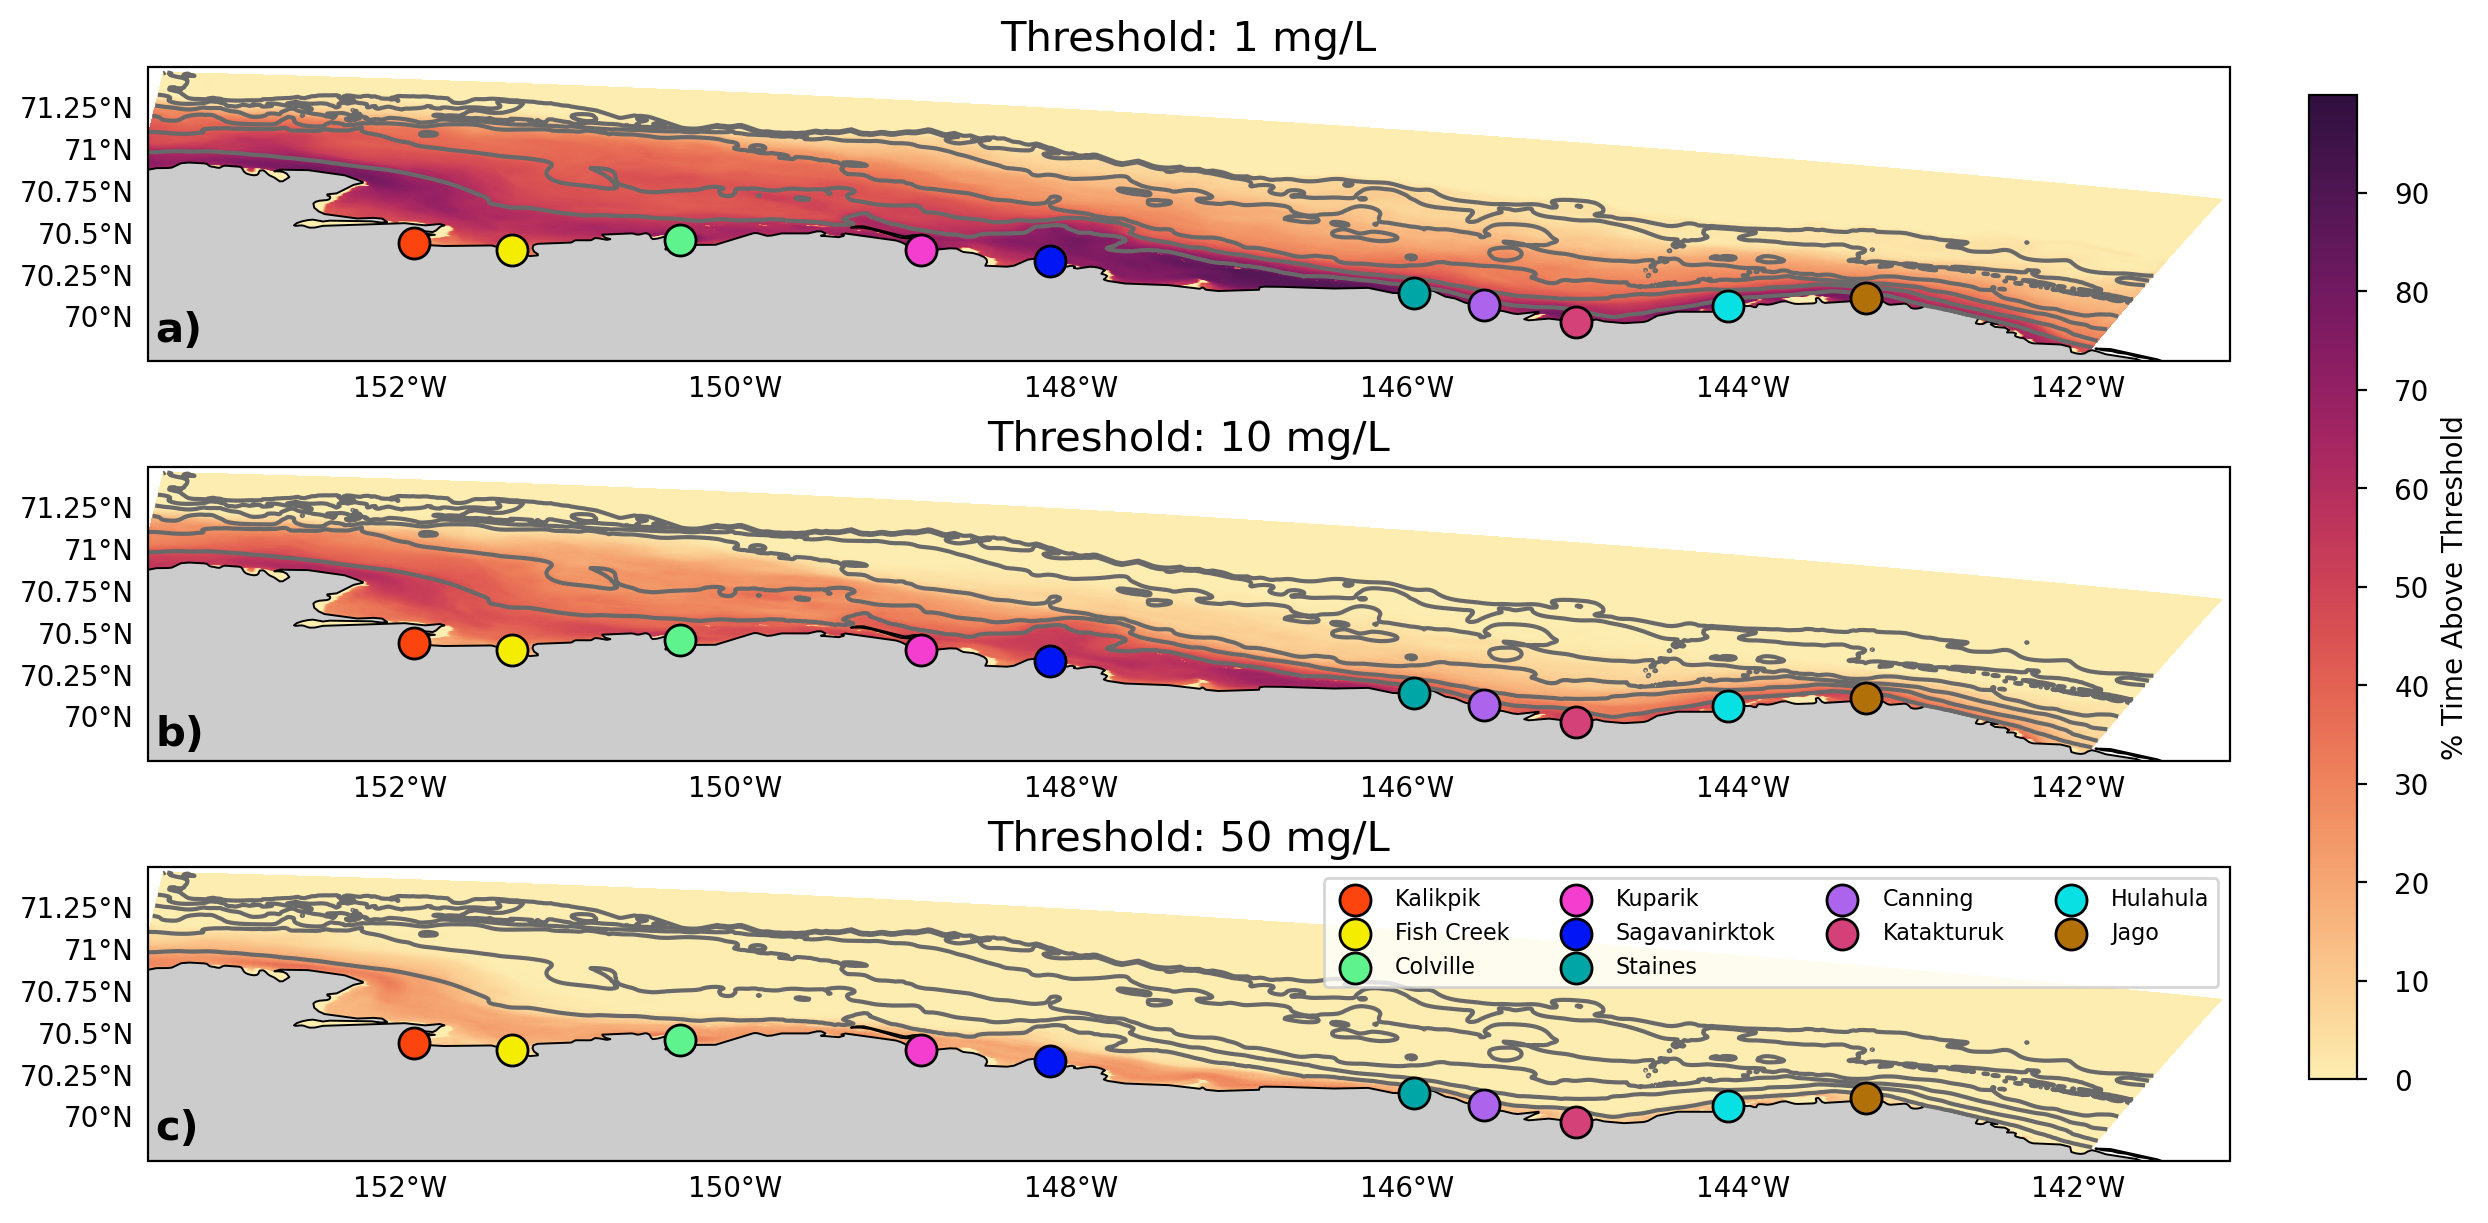

In [13]:
# Assuming they look the same, make a plot 
# with the values above the three different 
# thresholds 

# Make the figure
fig, ax = plt.subplots(3, figsize=(16,6), dpi=200,
                       constrained_layout=True,
                       subplot_kw={'projection': crs}) # figsize=(12,4.5). (16,6)
# Set the overall title/time
#fig1.suptitle('Time: ' + str(ds.ocean_time.values[t])[:10], x=0.5, y=1.02)

cs2 = ax[0].contourf(grid.lon_rho.values, grid.lat_rho.values, time_above_threshold_unag.time_above_threshold_01*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[0].set_title('Threshold: 1 mg/L', fontsize=fontsize-5) # 0.001 kg/m3

cs3 = ax[1].contourf(grid.lon_rho.values, grid.lat_rho.values, time_above_threshold_unag.time_above_threshold_02*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[1].set_title('Threshold: 10 mg/L', fontsize=fontsize-5) # 0.01 kg/m3

cs3 = ax[2].contourf(grid.lon_rho.values, grid.lat_rho.values, time_above_threshold_unag.time_above_threshold_03*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[2].set_title('Threshold: 50 mg/L', fontsize=fontsize-5) # 0.05 kg/m3

# Plot the colorbar 
cbar_ax1 = fig.add_axes([0.85,0.11,0.015,0.82])
cbar1 = plt.colorbar(cs3,extend='max',
             label='% Time Above Threshold',
              cax=cbar_ax1)

#ax.set_title('Time: ' +str(ds.ocean_time.values[t])[:10] + '\nSurface Salinity & Stress') #Only display yyyy-mm-dd


# Loop through axes and plot the river mouths
for r in range(3):
    # Set extent and map features
    ax[r].set_extent([-153.5,-141.1,69.75, 71.5],ccrs.PlateCarree())
    ax[r].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='0.8'), linewidth=.7)
    ax[r].coastlines(resolution='10m', linewidth=.7)

    # Plot the gridlines and stuff?
    gl1 = ax[r].gridlines(crs=ccrs.PlateCarree(), 
                    draw_labels=True, 
                    x_inline=False, y_inline=False, 
                    linewidth=0.33, color='#00000000',alpha=0)
    gl1.right_labels = gl1.top_labels = False
    gl1.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl1.xlabel_style = {'rotation': 0, 'ha': 'center'}

    # Plot bathymetry contours
    lev_bathy = np.arange(10,70,10)
    ax[r].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h, levels=lev_bathy, colors='dimgrey',
    linewidth=1)

    # Add in the rivers
    # Plot the 14 rivers in the grid
    # Go from West to East
    # Kalikpik River
    eta_kal_idx = 23 #22
    xi_kal_idx = 87
    s1 = ax[r].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik',
                transform=ccrs.PlateCarree(), zorder=500)

    # Fish Creek
    eta_fis_idx = 20
    xi_fis_idx = 117 #116
    s2 = ax[r].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek',
                transform=ccrs.PlateCarree(), zorder=500)

    # Colville River
    eta_col_idx = 39
    xi_col_idx = 166 #166
    s3 = ax[r].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville',
                transform=ccrs.PlateCarree(), zorder=500)

    # Kuparik
    # Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
    # of the Kuparuk River
    eta_kuk_idx = 41 #40
    xi_kuk_idx = 239
    eta_kup_idx = 41 #40
    xi_kup_idx = 242
    s5 = ax[r].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik',
                transform=ccrs.PlateCarree(), zorder=500)

    # Sagavanirktok River
    eta_sag_idx = 37 #36
    xi_sag_idx = 279
    s9 = ax[r].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok',
                transform=ccrs.PlateCarree(), zorder=500)

    # Canning River
    # Staines River
    eta_sta_idx = 27 #26
    xi_sta_idx = 393
    s10 = ax[r].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines',
                transform=ccrs.PlateCarree(), zorder=500)

    # Canning River
    eta_can_idx = 20 #19
    xi_can_idx = 416
    s11 = ax[r].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning',
                transform=ccrs.PlateCarree(), zorder=500)

    # Katakturuk River
    eta_kat_idx = 9 #8
    xi_kat_idx = 447
    s12 = ax[r].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk',
                transform=ccrs.PlateCarree(), zorder=500)

    # Hulahula River
    eta_hul_idx = 40
    xi_hul_idx = 489
    s13 = ax[r].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula',
                transform=ccrs.PlateCarree(), zorder=500)

    # Jago River
    eta_jag_idx = 62 #61
    xi_jag_idx = 528
    s14 = ax[r].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago',
                transform=ccrs.PlateCarree(), zorder=500)


# Make a legend
ax[2].legend(ncol=4, loc='upper right', fontsize=8)

# Add subplot labels
fig.text(0.177, 0.725, 'a)', color='black', fontsize=fontsize-5, weight='bold')
fig.text(0.177, 0.388, 'b)', color='black', fontsize=fontsize-5, weight='bold')
fig.text(0.177, 0.060, 'c)', color='black', fontsize=fontsize-5, weight='bold')

# Plot the plot?
fig.canvas.draw()



In [14]:
lev_bathy

array([10, 20, 30, 40, 50, 60])

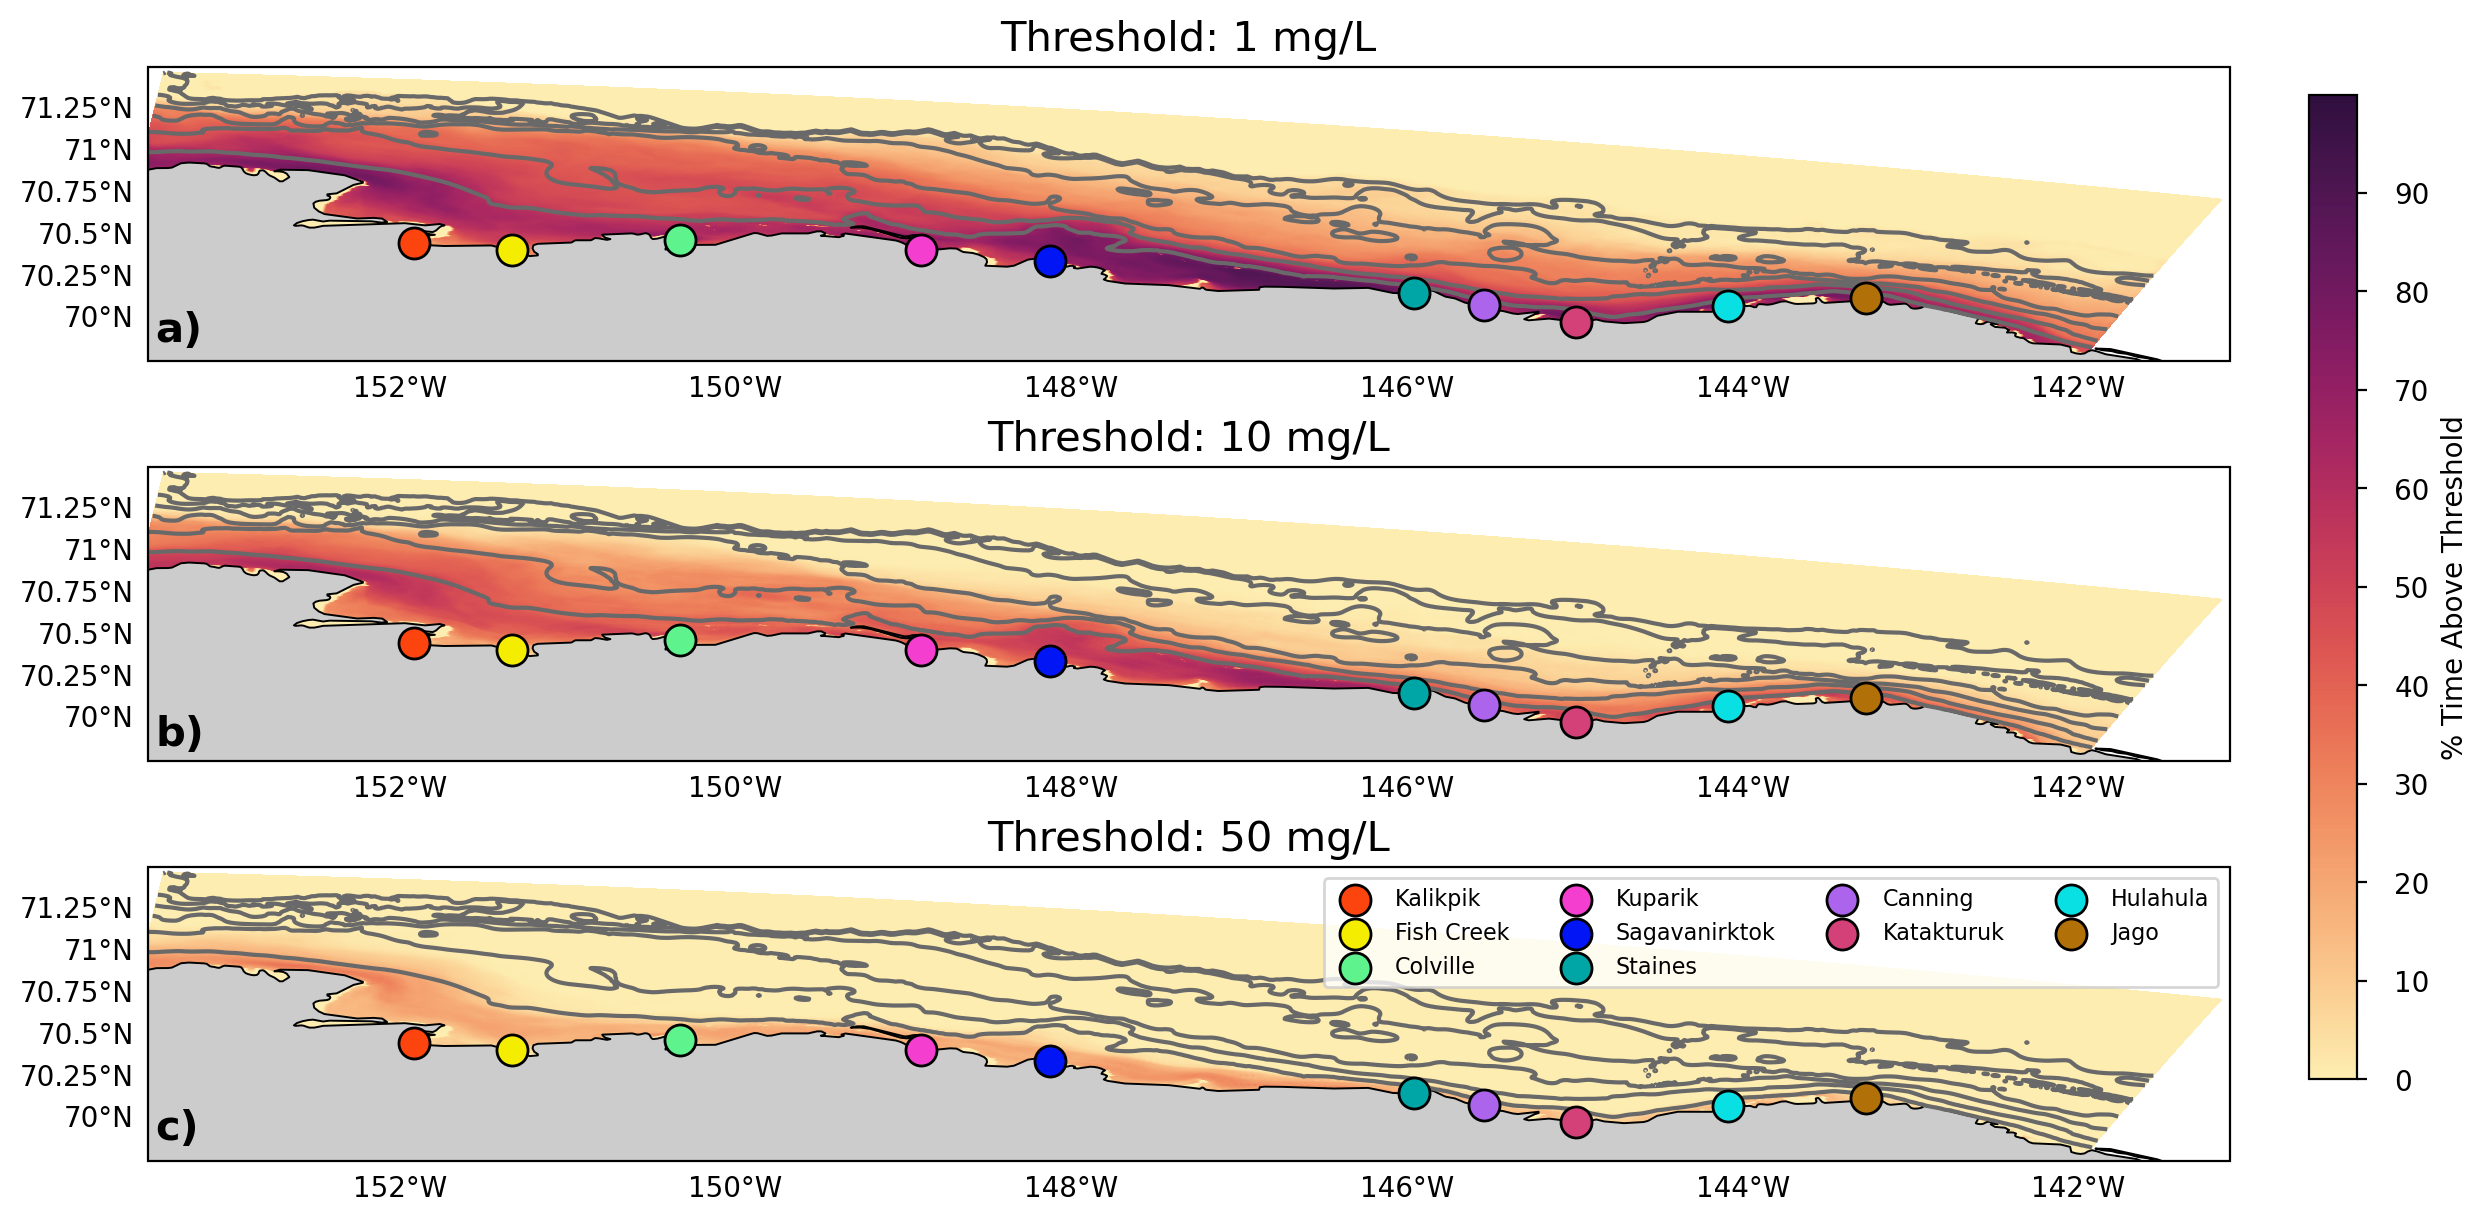

In [15]:
# Make same plot but for aggregated mud output

# Make the figure
fig, ax = plt.subplots(3, figsize=(16,6), dpi=200,
                       constrained_layout=True,
                       subplot_kw={'projection': crs}) # figsize=(12,4.5). (16,6)
# Set the overall title/time
#fig1.suptitle('Time: ' + str(ds.ocean_time.values[t])[:10], x=0.5, y=1.02)

cs2 = ax[0].contourf(grid.lon_rho.values, grid.lat_rho.values, time_above_threshold_agg.time_above_threshold_01*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[0].set_title('Threshold: 1 mg/L', fontsize=fontsize-5) # 0.001 kg/m3

cs3 = ax[1].contourf(grid.lon_rho.values, grid.lat_rho.values, time_above_threshold_agg.time_above_threshold_02*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[1].set_title('Threshold: 10 mg/L', fontsize=fontsize-5) # 0.01 kg/m3

cs3 = ax[2].contourf(grid.lon_rho.values, grid.lat_rho.values, time_above_threshold_agg.time_above_threshold_03*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[2].set_title('Threshold: 50 mg/L', fontsize=fontsize-5) # 0.05 kg/m3 

# Plot the colorbar 
cbar_ax1 = fig.add_axes([0.85,0.11,0.015,0.82])
cbar1 = plt.colorbar(cs3,extend='max',
             label='% Time Above Threshold',
              cax=cbar_ax1)

#ax.set_title('Time: ' +str(ds.ocean_time.values[t])[:10] + '\nSurface Salinity & Stress') #Only display yyyy-mm-dd


# Loop through axes and plot the river mouths
for r in range(3):
    # Set extent and map features
    ax[r].set_extent([-153.5,-141.1,69.75, 71.5],ccrs.PlateCarree())
    ax[r].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='0.8'), linewidth=.7)
    ax[r].coastlines(resolution='10m', linewidth=.7)

    # Plot the gridlines and stuff?
    gl1 = ax[r].gridlines(crs=ccrs.PlateCarree(), 
                    draw_labels=True, 
                    x_inline=False, y_inline=False, 
                    linewidth=0.33, color='#00000000',alpha=0)
    gl1.right_labels = gl1.top_labels = False
    gl1.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl1.xlabel_style = {'rotation': 0, 'ha': 'center'}

    # Plot bathymetry contours
    lev_bathy = np.arange(10,70,10)
    ax[r].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h, levels=lev_bathy, colors='dimgrey',
    linewidth=1)

    # Add in the rivers
    # Plot the 14 rivers in the grid
    # Go from West to East
    # Kalikpik River
    eta_kal_idx = 23 #22
    xi_kal_idx = 87
    s1 = ax[r].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik',
                transform=ccrs.PlateCarree(), zorder=500)

    # Fish Creek
    eta_fis_idx = 20
    xi_fis_idx = 117 #116
    s2 = ax[r].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek',
                transform=ccrs.PlateCarree(), zorder=500)

    # Colville River
    eta_col_idx = 39
    xi_col_idx = 166 #166
    s3 = ax[r].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville',
                transform=ccrs.PlateCarree(), zorder=500)

    # Kuparik
    # Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
    # of the Kuparuk River
    eta_kuk_idx = 41 #40
    xi_kuk_idx = 239
    eta_kup_idx = 41 #40
    xi_kup_idx = 242
    s5 = ax[r].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik',
                transform=ccrs.PlateCarree(), zorder=500)

    # Sagavanirktok River
    eta_sag_idx = 37 #36
    xi_sag_idx = 279
    s9 = ax[r].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok',
                transform=ccrs.PlateCarree(), zorder=500)

    # Canning River
    # Staines River
    eta_sta_idx = 27 #26
    xi_sta_idx = 393
    s10 = ax[r].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines',
                transform=ccrs.PlateCarree(), zorder=500)

    # Canning River
    eta_can_idx = 20 #19
    xi_can_idx = 416
    s11 = ax[r].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning',
                transform=ccrs.PlateCarree(), zorder=500)

    # Katakturuk River
    eta_kat_idx = 9 #8
    xi_kat_idx = 447
    s12 = ax[r].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk',
                transform=ccrs.PlateCarree(), zorder=500)

    # Hulahula River
    eta_hul_idx = 40
    xi_hul_idx = 489
    s13 = ax[r].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula',
                transform=ccrs.PlateCarree(), zorder=500)

    # Jago River
    eta_jag_idx = 62 #61
    xi_jag_idx = 528
    s14 = ax[r].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago',
                transform=ccrs.PlateCarree(), zorder=500)


# Make a legend
ax[2].legend(ncol=4, loc='upper right', fontsize=8)

# Add subplot labels
fig.text(0.177, 0.725, 'a)', color='black', fontsize=fontsize-5, weight='bold')
fig.text(0.177, 0.388, 'b)', color='black', fontsize=fontsize-5, weight='bold')
fig.text(0.177, 0.060, 'c)', color='black', fontsize=fontsize-5, weight='bold')


# Plot the plot?
fig.canvas.draw()

In [16]:
# Load in the rho masks 
mask_rho_nan = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_ones_nans.nc') # UPDATE PATH

In [17]:
# Set the number of cells in the sponge on each open boundary
c_west = 36
c_north = 45
c_east = 36

# Make it so land will appear
temp_mask = grid.mask_rho.copy()
temp_mask = np.where(temp_mask==0, np.nan, temp_mask)

# Prep the data by  ultiplying by the mask and trimming
# Multiply by mask and trim 
h_masked = grid.h.values*grid.mask_rho.values*mask_rho_nan.nudge_mask_rho_nan
h_masked_trimmed = h_masked[:,c_west:-c_west]
# Threshlold 1
time_above_threshold_01_masked = time_above_threshold_agg.time_above_threshold_01*grid.mask_rho.values*mask_rho_nan.nudge_mask_rho_nan
time_above_threshold_01_masked_trimmed = time_above_threshold_01_masked[:,c_west:-c_west]
# Threshlold 2
time_above_threshold_02_masked = time_above_threshold_agg.time_above_threshold_02*grid.mask_rho.values*mask_rho_nan.nudge_mask_rho_nan
time_above_threshold_02_masked_trimmed = time_above_threshold_02_masked[:,c_west:-c_west]
# Threshlold 3
time_above_threshold_03_masked = time_above_threshold_agg.time_above_threshold_03*grid.mask_rho.values*mask_rho_nan.nudge_mask_rho_nan
time_above_threshold_03_masked_trimmed = time_above_threshold_03_masked[:,c_west:-c_west]

lon_rho_trimmed = grid.lon_rho[:,c_west:-c_west].values
lat_rho_trimmed = grid.lat_rho[:,c_west:-c_west].values

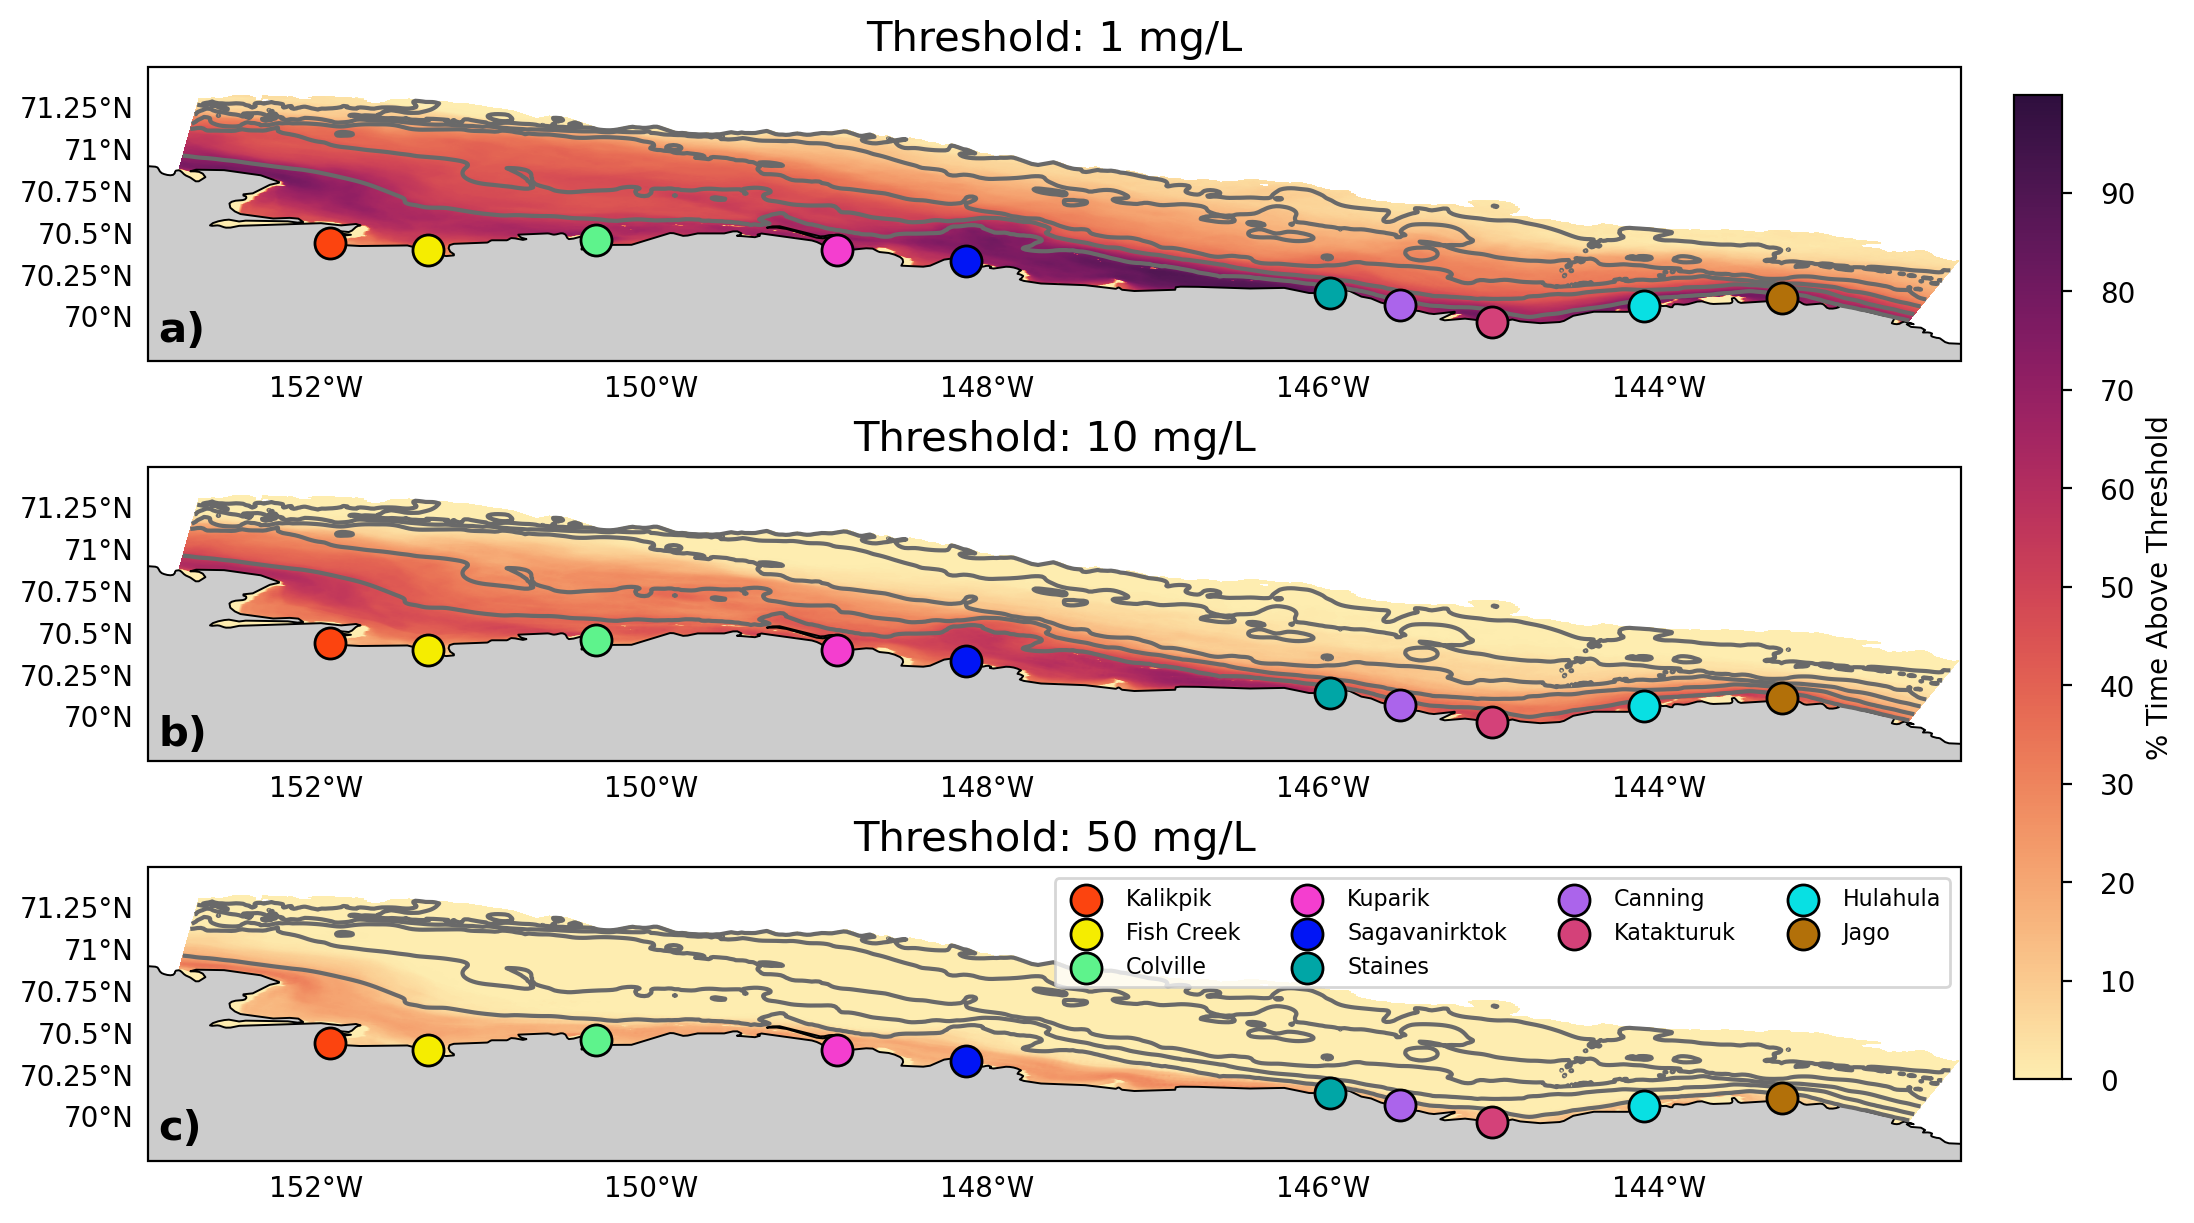

In [18]:
# Make another versio of this plot that 
# excludes the regions we don't trust 

# Make the figure
fig, ax = plt.subplots(3, figsize=(16,6), dpi=200,
                       constrained_layout=True,
                       subplot_kw={'projection': crs}) # figsize=(12,4.5). (16,6)
# Set the overall title/time
#fig1.suptitle('Time: ' + str(ds.ocean_time.values[t])[:10], x=0.5, y=1.02)

cs2 = ax[0].contourf(lon_rho_trimmed, lat_rho_trimmed, time_above_threshold_01_masked_trimmed*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[0].set_title('Threshold: 1 mg/L', fontsize=fontsize-5) # 0.001 kg/m3

cs3 = ax[1].contourf(lon_rho_trimmed, lat_rho_trimmed, time_above_threshold_02_masked_trimmed*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[1].set_title('Threshold: 10 mg/L', fontsize=fontsize-5) # 0.01 kg/m3

cs3 = ax[2].contourf(lon_rho_trimmed, lat_rho_trimmed, time_above_threshold_03_masked_trimmed*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[2].set_title('Threshold: 50 mg/L', fontsize=fontsize-5) # 0.05 kg/m3 

# Plot the colorbar 
cbar_ax1 = fig.add_axes([0.80,0.11,0.015,0.82])
cbar1 = plt.colorbar(cs3,extend='max',
             label='% Time Above Threshold',
              cax=cbar_ax1)

#ax.set_title('Time: ' +str(ds.ocean_time.values[t])[:10] + '\nSurface Salinity & Stress') #Only display yyyy-mm-dd


# Loop through axes and plot the river mouths
for r in range(3):
    # Set extent and map features
    #ax[r].set_extent([-153.5,-141.1,69.75, 71.5],ccrs.PlateCarree())
    ax[r].set_extent([-153,-142.2,69.75, 71.5],ccrs.PlateCarree())
    ax[r].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='0.8'), linewidth=.7)
    ax[r].coastlines(resolution='10m', linewidth=.7)

    # Plot the gridlines and stuff?
    gl1 = ax[r].gridlines(crs=ccrs.PlateCarree(), 
                    draw_labels=True, 
                    x_inline=False, y_inline=False, 
                    linewidth=0.33, color='#00000000',alpha=0)
    gl1.right_labels = gl1.top_labels = False
    gl1.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl1.xlabel_style = {'rotation': 0, 'ha': 'center'}

    # Plot bathymetry contours
    lev_bathy = np.arange(10,70,10)
    ax[r].contour(lon_rho_trimmed, lat_rho_trimmed, h_masked_trimmed, levels=lev_bathy, colors='dimgrey',
    linewidth=1)

    # Add in the rivers
    # Plot the 14 rivers in the grid
    # Go from West to East
    # Kalikpik River
    eta_kal_idx = 23 #22
    xi_kal_idx = 87
    s1 = ax[r].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik',
                transform=ccrs.PlateCarree(), zorder=500)

    # Fish Creek
    eta_fis_idx = 20
    xi_fis_idx = 117 #116
    s2 = ax[r].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek',
                transform=ccrs.PlateCarree(), zorder=500)

    # Colville River
    eta_col_idx = 39
    xi_col_idx = 166 #166
    s3 = ax[r].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville',
                transform=ccrs.PlateCarree(), zorder=500)

    # Kuparik
    # Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
    # of the Kuparuk River
    eta_kuk_idx = 41 #40
    xi_kuk_idx = 239
    eta_kup_idx = 41 #40
    xi_kup_idx = 242
    s5 = ax[r].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik',
                transform=ccrs.PlateCarree(), zorder=500)

    # Sagavanirktok River
    eta_sag_idx = 37 #36
    xi_sag_idx = 279
    s9 = ax[r].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok',
                transform=ccrs.PlateCarree(), zorder=500)

    # Canning River
    # Staines River
    eta_sta_idx = 27 #26
    xi_sta_idx = 393
    s10 = ax[r].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines',
                transform=ccrs.PlateCarree(), zorder=500)

    # Canning River
    eta_can_idx = 20 #19
    xi_can_idx = 416
    s11 = ax[r].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning',
                transform=ccrs.PlateCarree(), zorder=500)

    # Katakturuk River
    eta_kat_idx = 9 #8
    xi_kat_idx = 447
    s12 = ax[r].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk',
                transform=ccrs.PlateCarree(), zorder=500)

    # Hulahula River
    eta_hul_idx = 40
    xi_hul_idx = 489
    s13 = ax[r].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula',
                transform=ccrs.PlateCarree(), zorder=500)

    # Jago River
    eta_jag_idx = 62 #61
    xi_jag_idx = 528
    s14 = ax[r].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago',
                transform=ccrs.PlateCarree(), zorder=500)


# Make a legend
ax[2].legend(ncol=4, loc='upper right', fontsize=8)

# Add subplot labels
fig.text(0.220, 0.725, 'a)', color='black', fontsize=fontsize-5, weight='bold')
fig.text(0.220, 0.388, 'b)', color='black', fontsize=fontsize-5, weight='bold')
fig.text(0.220, 0.060, 'c)', color='black', fontsize=fontsize-5, weight='bold')


# Plot the plot?
fig.canvas.draw()


#### Statistics!
Calculate and print a bunch of statistics!

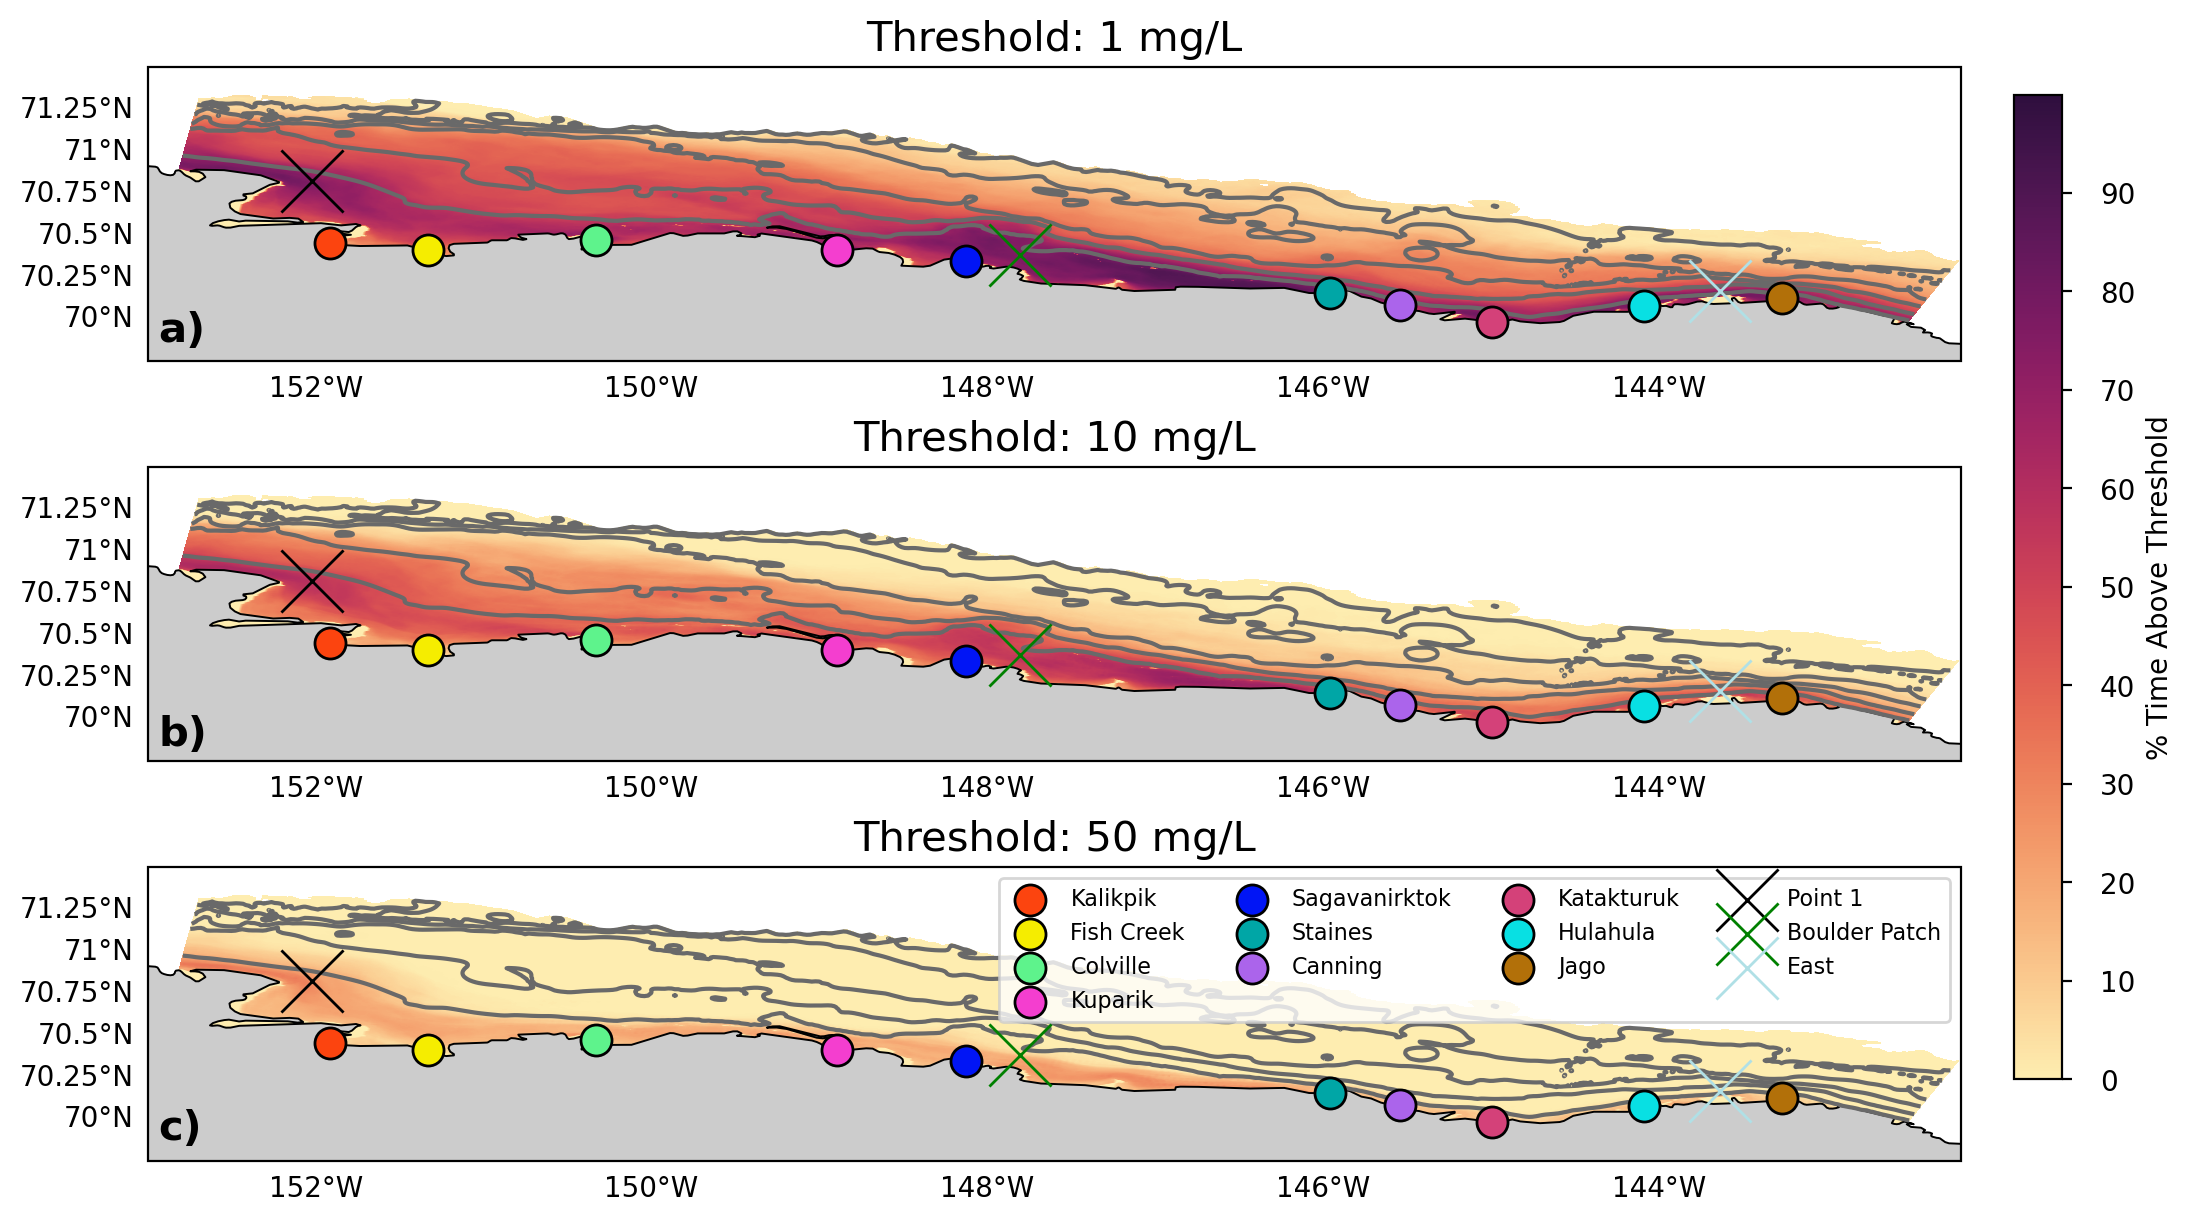

In [34]:
# Find the regions I want

# Make the figure
fig, ax = plt.subplots(3, figsize=(16,6), dpi=200,
                       constrained_layout=True,
                       subplot_kw={'projection': crs}) # figsize=(12,4.5). (16,6)
# Set the overall title/time
#fig1.suptitle('Time: ' + str(ds.ocean_time.values[t])[:10], x=0.5, y=1.02)

cs2 = ax[0].contourf(lon_rho_trimmed, lat_rho_trimmed, time_above_threshold_01_masked_trimmed*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[0].set_title('Threshold: 1 mg/L', fontsize=fontsize-5) # 0.001 kg/m3

cs3 = ax[1].contourf(lon_rho_trimmed, lat_rho_trimmed, time_above_threshold_02_masked_trimmed*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[1].set_title('Threshold: 10 mg/L', fontsize=fontsize-5) # 0.01 kg/m3

cs3 = ax[2].contourf(lon_rho_trimmed, lat_rho_trimmed, time_above_threshold_03_masked_trimmed*100,
                   cmap=cmocean.cm.matter, levels=lev_pcnt)
ax[2].set_title('Threshold: 50 mg/L', fontsize=fontsize-5) # 0.05 kg/m3 

# Plot the colorbar 
cbar_ax1 = fig.add_axes([0.80,0.11,0.015,0.82])
cbar1 = plt.colorbar(cs3,extend='max',
             label='% Time Above Threshold',
              cax=cbar_ax1)

#ax.set_title('Time: ' +str(ds.ocean_time.values[t])[:10] + '\nSurface Salinity & Stress') #Only display yyyy-mm-dd


# Loop through axes and plot the river mouths
for r in range(3):
    # Set extent and map features
    #ax[r].set_extent([-153.5,-141.1,69.75, 71.5],ccrs.PlateCarree())
    ax[r].set_extent([-153,-142.2,69.75, 71.5],ccrs.PlateCarree())
    ax[r].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='0.8'), linewidth=.7)
    ax[r].coastlines(resolution='10m', linewidth=.7)

    # Plot the gridlines and stuff?
    gl1 = ax[r].gridlines(crs=ccrs.PlateCarree(), 
                    draw_labels=True, 
                    x_inline=False, y_inline=False, 
                    linewidth=0.33, color='#00000000',alpha=0)
    gl1.right_labels = gl1.top_labels = False
    gl1.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl1.xlabel_style = {'rotation': 0, 'ha': 'center'}

    # Plot bathymetry contours
    lev_bathy = np.arange(10,70,10)
    ax[r].contour(lon_rho_trimmed, lat_rho_trimmed, h_masked_trimmed, levels=lev_bathy, colors='dimgrey',
    linewidth=1)

    # Add in the rivers
    # Plot the 14 rivers in the grid
    # Go from West to East
    # Kalikpik River
    eta_kal_idx = 23 #22
    xi_kal_idx = 87
    s1 = ax[r].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik',
                transform=ccrs.PlateCarree(), zorder=500)

    # Fish Creek
    eta_fis_idx = 20
    xi_fis_idx = 117 #116
    s2 = ax[r].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek',
                transform=ccrs.PlateCarree(), zorder=500)

    # Colville River
    eta_col_idx = 39
    xi_col_idx = 166 #166
    s3 = ax[r].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville',
                transform=ccrs.PlateCarree(), zorder=500)

    # Kuparik
    # Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
    # of the Kuparuk River
    eta_kuk_idx = 41 #40
    xi_kuk_idx = 239
    eta_kup_idx = 41 #40
    xi_kup_idx = 242
    s5 = ax[r].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik',
                transform=ccrs.PlateCarree(), zorder=500)

    # Sagavanirktok River
    eta_sag_idx = 37 #36
    xi_sag_idx = 279
    s9 = ax[r].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok',
                transform=ccrs.PlateCarree(), zorder=500)

    # Canning River
    # Staines River
    eta_sta_idx = 27 #26
    xi_sta_idx = 393
    s10 = ax[r].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines',
                transform=ccrs.PlateCarree(), zorder=500)

    # Canning River
    eta_can_idx = 20 #19
    xi_can_idx = 416
    s11 = ax[r].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning',
                transform=ccrs.PlateCarree(), zorder=500)

    # Katakturuk River
    eta_kat_idx = 9 #8
    xi_kat_idx = 447
    s12 = ax[r].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk',
                transform=ccrs.PlateCarree(), zorder=500)

    # Hulahula River
    eta_hul_idx = 40
    xi_hul_idx = 489
    s13 = ax[r].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula',
                transform=ccrs.PlateCarree(), zorder=500)

    # Jago River
    eta_jag_idx = 62 #61
    xi_jag_idx = 528
    s14 = ax[r].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago',
                transform=ccrs.PlateCarree(), zorder=500)
    
    # Location of interest
    ax[r].scatter(lon_rho_trimmed[92, 40], lat_rho_trimmed[92, 40], 
                marker='x', s=500, linewidth=1, edgecolors='black', color='black', label='Point 1',
                transform=ccrs.PlateCarree(), zorder=500)

    # Stefansson Sound Boulder Patch
    ax[r].scatter(grid.lon_rho[47, 294].values, grid.lat_rho[47, 294].values, 
                marker='x', s=500, linewidth=1, edgecolors='green', color='green', label='Boulder Patch',
                transform=ccrs.PlateCarree(), zorder=500)
    
    # Eastern location 
    ax[r].scatter(grid.lon_rho[64, 508].values, grid.lat_rho[64, 508].values, 
                marker='x', s=500, linewidth=1, edgecolors='powderblue', color='powderblue', label='East',
                transform=ccrs.PlateCarree(), zorder=500)


# Make a legend
ax[2].legend(ncol=4, loc='upper right', fontsize=8)

# Add subplot labels
fig.text(0.220, 0.725, 'a)', color='black', fontsize=fontsize-5, weight='bold')
fig.text(0.220, 0.388, 'b)', color='black', fontsize=fontsize-5, weight='bold')
fig.text(0.220, 0.060, 'c)', color='black', fontsize=fontsize-5, weight='bold')


# Plot the plot?
fig.canvas.draw()

In [20]:
# Find the percent of time that the region 
# offshore Kalikpik River exceeded 10 amd 50 mg/L

# Set the indices
eta_west_high_idx = 92
xi_west_high_idx = 40

# Get the values there
print('time above 1 mg/L at eta_west_high_idx: ', time_above_threshold_01_masked_trimmed[eta_west_high_idx, xi_west_high_idx].values*100)
print('time above 10 mg/L at eta_west_high_idx: ', time_above_threshold_02_masked_trimmed[eta_west_high_idx, xi_west_high_idx].values*100)
print('time above 50 mg/L at eta_west_high_idx: ', time_above_threshold_03_masked_trimmed[eta_west_high_idx, xi_west_high_idx].values*100)
print('depth at eta_west_high_idx: ', h_masked_trimmed[eta_west_high_idx, xi_west_high_idx].values)



time above 1 mg/L at eta_west_high_idx:  74.64788732394366
time above 10 mg/L at eta_west_high_idx:  56.978233034571055
time above 50 mg/L at eta_west_high_idx:  26.76056338028169
depth at eta_west_high_idx:  5.897920834269767


In [36]:
# Find stats offshore Hulahula and Jago

# Set the indices
eta_east_high_idx = 64
xi_east_high_idx = 508

# Get the values there
print('time above 1 mg/L at eta_east_high_idx: ', time_above_threshold_01_masked_trimmed[eta_east_high_idx, xi_east_high_idx].values*100)
print('time above 10 mg/L at eta_east_high_idx: ', time_above_threshold_02_masked_trimmed[eta_east_high_idx, xi_east_high_idx].values*100)
print('time above 50 mg/L at eta_east_high_idx: ', time_above_threshold_03_masked_trimmed[eta_east_high_idx, xi_east_high_idx].values*100)
print('depth at eta_east_high_idx: ', h_masked_trimmed[eta_east_high_idx, xi_east_high_idx].values)

time above 1 mg/L at eta_east_high_idx:  62.86811779769527
time above 10 mg/L at eta_east_high_idx:  35.723431498079385
time above 50 mg/L at eta_east_high_idx:  0.2560819462227913
depth at eta_east_high_idx:  12.84080934817788


In [20]:
# Get the average percent of time that 1 mg/L was 
# exceeded on the shelf
# Multiply by mask to get nans instead of 0s for average 
avg_time_above_1mgL = np.mean(time_above_threshold_01_masked_trimmed*temp_mask[:,c_west:-c_west]*100)
print('avg_time_above_1mgL: ', avg_time_above_1mgL.values)
avg_time_above_10mgL = np.mean(time_above_threshold_02_masked_trimmed*temp_mask[:,c_west:-c_west]*100)
print('avg_time_above_10mgL: ', avg_time_above_10mgL.values)
avg_time_above_50mgL = np.mean(time_above_threshold_03_masked_trimmed*temp_mask[:,c_west:-c_west]*100)
print('avg_time_above_50mgL: ', avg_time_above_50mgL.values)

# Get mins
min_time_above_1mgL = np.min(time_above_threshold_01_masked_trimmed*temp_mask[:,c_west:-c_west]*100)
print('min_time_above_1mgL: ', min_time_above_1mgL.values)
min_time_above_10mgL = np.min(time_above_threshold_02_masked_trimmed*temp_mask[:,c_west:-c_west]*100)
print('min_time_above_10mgL: ', min_time_above_10mgL.values)
min_time_above_50mgL = np.min(time_above_threshold_03_masked_trimmed*temp_mask[:,c_west:-c_west]*100)
print('min_time_above_50mgL: ', min_time_above_50mgL.values)

# Get maxs
max_time_above_1mgL = np.max(time_above_threshold_01_masked_trimmed*temp_mask[:,c_west:-c_west]*100)
print('max_time_above_1mgL: ', max_time_above_1mgL.values)
max_time_above_10mgL = np.max(time_above_threshold_02_masked_trimmed*temp_mask[:,c_west:-c_west]*100)
print('max_time_above_10mgL: ', max_time_above_10mgL.values)
max_time_above_50mgL = np.max(time_above_threshold_03_masked_trimmed*temp_mask[:,c_west:-c_west]*100)
print('max_time_above_50mgL: ', max_time_above_50mgL.values)

avg_time_above_1mgL:  35.7751043177824
avg_time_above_10mgL:  18.774135159630024
avg_time_above_50mgL:  3.1144123990556984
min_time_above_1mgL:  0.0
min_time_above_10mgL:  0.0
min_time_above_50mgL:  0.0
max_time_above_1mgL:  95.13444302176697
max_time_above_10mgL:  86.93982074263764
max_time_above_50mgL:  46.094750320102435


In [21]:
time_above_threshold_01_masked_trimmed*temp_mask[:,c_west:-c_west][0,0]

<xarray.DataArray (eta_rho: 206, xi_rho: 536)> Size: 883kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(206, 536))
Coordinates:
  * xi_rho   (xi_rho) float64 4kB 36.0 37.0 38.0 39.0 ... 569.0 570.0 571.0
  * eta_rho  (eta_rho) float64 2kB 0.0 1.0 2.0 3.0 ... 202.0 203.0 204.0 205.0

In [30]:
# Find the percent of time above the different 
# thresholds near the Stefansson Sound Boulder Patch
# Set the indices
eta_boulder_idx = 47
xi_boulder_idx = 294

# Get the values there
print('time above 1 mg/L at eta_boulder_idx: ', time_above_threshold_01_masked_trimmed[eta_boulder_idx, xi_boulder_idx].values*100)
print('time above 10 mg/L at eta_boulder_idx: ', time_above_threshold_02_masked_trimmed[eta_boulder_idx, xi_boulder_idx].values*100)
print('time above 50 mg/L at eta_boulder_idx: ', time_above_threshold_03_masked_trimmed[eta_boulder_idx, xi_boulder_idx].values*100)

time above 1 mg/L at eta_boulder_idx:  76.31241997439182
time above 10 mg/L at eta_boulder_idx:  49.42381562099872
time above 50 mg/L at eta_boulder_idx:  0.6402048655569782
